In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("categorized_tweets.csv",encoding="ISO-8859-1")
df.head()
df = df[df["Category"] != "damaged_infrastructure"] #comment out if ypu want to use damaged infrastructure set.
df = df[df["Category"] != "shooting"]
df = df[df["Category"] != "crash"]

In [4]:
col = ["Category", "Tweet"]
df = df[col]
df.columns = ['Category', 'Tweet']
df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)
df.head()

,Category,Tweet,category_id
0,fire,Firefighters battle a two-alarm blaze at 54 Ma...,0
1,fire,Pray for Fort McMurray \n#forrestfire #cl415 #...,0
2,fire,Addison and McGraw. E42X stretched. #fourthofj...,0
3,fire,With fire season starting my brother is a hots...,0
4,fire,These Forrest fires are OUT OF CONTROL! ðð...,0


In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Category').Tweet.count().plot.bar(ylim=0)
plt.show()

Pretty even split of data. If using damaged infrastructure set, there's a huge class imbalance. 

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Tweet).toarray()
labels = df.category_id
features.shape

(2080, 1190)

In [7]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Category, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Category))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'NO':
  . Most correlated unigrams:
. forrestfire
. floodwater
  . Most correlated bigrams:
. spring break
. flood floodwater
# 'fire':
  . Most correlated unigrams:
. buildingfire
. forrestfire
  . Most correlated bigrams:
. woodstock http
. dead woodstock
# 'flood':
  . Most correlated unigrams:
. accrafloods
. floodwater
  . Most correlated bigrams:
. hurricane sandy
. flood floodwater


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

X_train, X_test, y_train, y_test = train_test_split(df['Tweet'], df['Category'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
model = LinearSVC().fit(X_train_tfidf, y_train)

Look into different model types, LinearSVC, MultinomialNB, LogistciRegression and compare their accuricies

In [9]:
#Type in a sentence where it says Text here to see what it classifies it to
print(model.predict(count_vect.transform(['This party is fire'])))

['fire']


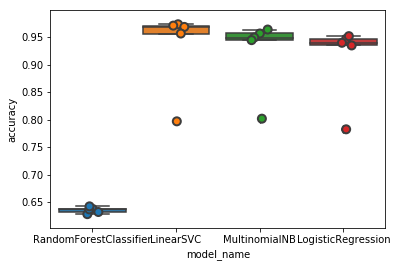

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
#plt.figure(figsize=(20,20))
plt.rcParams["figure.figsize"] = [6,6]
plt.show()

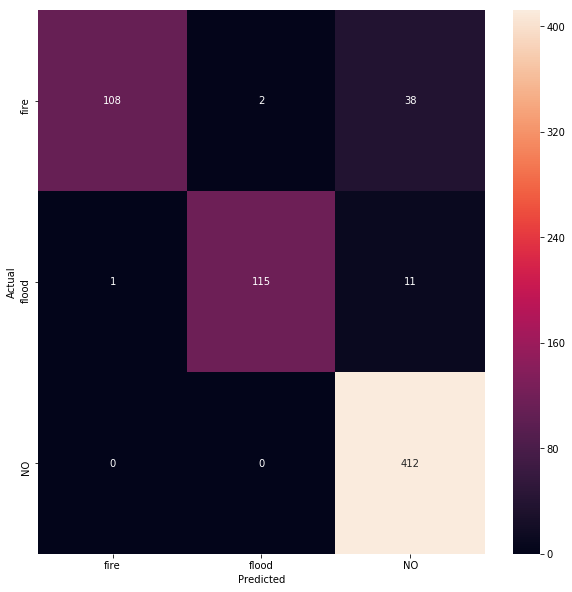

In [15]:
import seaborn as sns
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [12]:
plt.savefig('confusion.png')

In [14]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Category'].unique()))

             precision    recall  f1-score   support

       fire       0.99      0.73      0.84       148
      flood       0.98      0.91      0.94       127
         NO       0.89      1.00      0.94       412

avg / total       0.93      0.92      0.92       687

